In [33]:
from langgraph.types import Literal,Command
from langgraph.graph import StateGraph,START,END,MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.utilities import SQLDatabase
from langchain_deepseek import ChatDeepSeek
from dotenv import load_dotenv
from langchain.chains import create_sql_query_chain
from sqlalchemy import create_engine
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from typing_extensions import TypedDict,List,Optional,Annotated
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.messages import AIMessage
from langgraph.checkpoint.memory import InMemorySaver
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from pydantic import Field,BaseModel
import asyncio
import os
load_dotenv()

True

In [34]:
models=ChatNVIDIA.get_available_models()

In [35]:
models

[Model(id='google/codegemma-1.1-7b', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-codegemma-1.1-7b'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='upstage/solar-10.7b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-solar-10_7b-instruct'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='mistralai/mixtral-8x22b-instruct-v0.1', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-mixtral-8x22b-instruct'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='ai21labs/jamba-1.5-large-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='meta/llama-3.1-70b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None),
 M

In [36]:
memory = InMemorySaver()
config = {'configurable':{'thread_id':'1'}}

In [37]:
class State(MessagesState):
    sql_result_gemini : List[str] = Field(description='Result of the sql query',default=[])
    sql_result_deepseek : List[str] = Field(description="Result of the sql query",default=[])
    sql_result_llama : List[str] = Field(description="Result of the sql query",default=[])
    sql_result_nemotron : List[str] = Field(description="Result of the sql query",default=[])

In [38]:
gemini_model = ChatGoogleGenerativeAI(model='gemini-2.0-flash',temperature=0,top_p=0.95)
deepseek_model = ChatDeepSeek(model = 'deepseek-chat',temperature=0,top_p=0.95)
llama_70b = ChatNVIDIA(model='meta/llama-3.3-70b-instruct',temperature=0,top_p=0.95)
nemotron = ChatNVIDIA(model='nvidia/llama-3.3-nemotron-super-49b-v1',temperature=0,top_p=0.95)

c:\Users\gokul\anaconda3\envs\langgraphenv\Lib\site-packages\langchain_nvidia_ai_endpoints\_common.py:212: UserWarning: Found nvidia/llama-3.3-nemotron-super-49b-v1 in available_models, but type is unknown and inference may fail.
  warnings.warn(


In [39]:
db_user = 'root'
db_password = 'gokul'
db_host = 'localhost'
db_name = 'retail_sales_db'

engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}")

db = SQLDatabase(engine=engine)

In [40]:
toolkit = SQLDatabaseToolkit(db=db, llm=gemini_model)
tools = toolkit.get_tools()

In [41]:
def create_system_prompt():
    tool_names = ""
    tool_descriptions = ""
    for tool in tools:
        tool_names += f"{tool.name}, "
        tool_descriptions += f"{tool.description}, "

    sys_prompt = f""" You are a SQL Database manager, You can write sql queries and return results to the user,
    These are the available tools for you {tool_names} and their descriptions are {tool_descriptions}
    You can use these tools to get the information you need to answer the user's question.
    Always return the query along with the result if you use QueryTool only in a string and not in a list/dictionary
    These are the tables present in the database {db.get_table_names()}"""
    
    return sys_prompt

In [42]:
deepseek_agent = create_react_agent(
    model=deepseek_model,
    tools = tools,
    prompt=create_system_prompt(),
)

gemini_agent = create_react_agent(
    model=gemini_model,
    tools = tools,
    prompt = create_system_prompt(),
)

llama_agent = create_react_agent(
    model=llama_70b,
    tools = tools,
    prompt = create_system_prompt(),
)

nemotron_agent = create_react_agent(
    model=nemotron,
    tools = tools,
    prompt = create_system_prompt(),
)

c:\Users\gokul\anaconda3\envs\langgraphenv\Lib\site-packages\langchain_nvidia_ai_endpoints\chat_models.py:591: UserWarning: Model 'nvidia/llama-3.3-nemotron-super-49b-v1' is not known to support tools. Your tool binding may fail at inference time.
  warnings.warn(


In [43]:
# async def deepseek_sql(state:State):
#     prompt = state['messages'][-1].content
#     response = deepseek_agent.invoke({'messages':prompt})
#     state['sql_result_deepseek'] += [response['messages'].content]
#     return state

In [44]:
async def deepseek_sql(state:State):
    prompt = state['messages'][-1].content
    response = deepseek_agent.invoke({'messages':prompt})
    
    if 'sql_result_deepseek' not in state:
        state['sql_result_deepseek'] = []
        
    state['sql_result_deepseek'] += response['messages']

    return state

In [45]:
async def gemini_sql(state:State):
    prompt = state['messages'][-1].content
    response = gemini_agent.invoke({'messages':prompt})

    if 'sql_result_gemini' not in state:
        state['sql_result_gemini'] = []
        
    state['sql_result_gemini'] += response['messages']

    return state

In [46]:
async def llama_sql(state:State):
    prompt = state['messages'][-1].content
    response = llama_agent.invoke({'messages':prompt})

    if 'sql_result_llama' not in state:
        state['sql_result_llama'] = []
        
    state['sql_result_llama'] += response['messages']

    return state

In [47]:
async def nemotron_sql(state:State):
    prompt = state['messages'][-1].content
    response = nemotron_agent.invoke({'messages':prompt})

    if 'sql_result_nemotron' not in state:
        state['sql_result_nemotron'] = []
        
    state['sql_result_nemotron'] += response['messages']

    return state

In [48]:
def check_list_instance(response):
    if isinstance(response,list):
        combined_message = "\n".join(response)
        return combined_message
    return response

In [49]:
async def final_answers(state:State):
    ans_from_gemini = state['sql_result_gemini'][-1].content
    ans_from_deepseek = state['sql_result_deepseek'][-1].content
    ans_from_llama = state['sql_result_llama'][-1].content
    ans_from_nemotron = state['sql_result_nemotron'][-1].content

    ans_from_gemini=check_list_instance(ans_from_gemini)
    ans_from_deepseek=check_list_instance(ans_from_deepseek)
    ans_from_llama=check_list_instance(ans_from_llama)
    ans_from_nemotron=check_list_instance(ans_from_nemotron)
    
    state['messages']+= [AIMessage(content=ans_from_gemini)] + [AIMessage(content=ans_from_deepseek)] + [AIMessage(content=ans_from_llama)] + [AIMessage(content=ans_from_nemotron)]

    return state
    

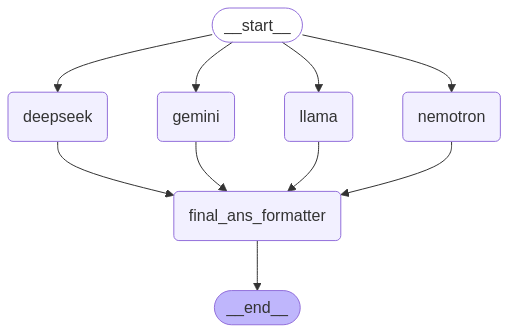

In [50]:
graph_builder = StateGraph(State)

graph_builder.add_node("deepseek",deepseek_sql)
graph_builder.add_node("gemini",gemini_sql)
graph_builder.add_node("llama",llama_sql)
graph_builder.add_node("nemotron",nemotron_sql)
graph_builder.add_node('final_ans_formatter',final_answers)


graph_builder.add_edge(START,"deepseek")
graph_builder.add_edge(START,"gemini")
graph_builder.add_edge(START,"llama")
graph_builder.add_edge(START,"nemotron")

graph_builder.add_edge("deepseek","final_ans_formatter")
graph_builder.add_edge("gemini","final_ans_formatter")
graph_builder.add_edge("llama","final_ans_formatter") 
graph_builder.add_edge("nemotron","final_ans_formatter")
graph_builder.add_edge("final_ans_formatter",END)

graph_builder.compile(checkpointer=memory)

In [51]:
graph = graph_builder.compile()

In [52]:
response = await graph.ainvoke({'messages':"How many male and female from age 19 in the sales table"},config=config)

In [53]:
response

{'messages': [HumanMessage(content='How many male and female from age 19 in the sales table', additional_kwargs={}, response_metadata={}, id='ef91529b-2887-41ac-b668-98b58e18e02c'),
  AIMessage(content='"\n```sql\nSELECT Gender, COUNT(*) FROM sales_tb WHERE Age = 19 GROUP BY Gender\n```\n\n\n{\'Gender\': \'Male\', \'COUNT(*)\': 1}"', additional_kwargs={}, response_metadata={}, id='563f92f7-a2ff-434b-84bf-c3c265e4c008'),
  AIMessage(content='There is 1 male customer aged 19 in the sales table, and no female customers of the same age.', additional_kwargs={}, response_metadata={}, id='cc0eded0-6c95-4a52-a941-f9b2b40075ad'),
  AIMessage(content='There is 1 male and 0 female from age 19 in the sales table.', additional_kwargs={}, response_metadata={}, id='4e784cbc-8fcf-4468-a9df-9fb12358582b'),
  AIMessage(content="**Query & Result**\n\n* **Query:** `SELECT gender, COUNT(*) as count FROM sales_tb WHERE age = 19 GROUP BY gender`\n* **Result:** `[('Male', 1)]`\n\n**Interpretation & Response**

In [54]:
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

How many male and female from age 19 in the sales table
================================== Ai Message ==================================

"
```sql
SELECT Gender, COUNT(*) FROM sales_tb WHERE Age = 19 GROUP BY Gender
```


{'Gender': 'Male', 'COUNT(*)': 1}"
================================== Ai Message ==================================

There is 1 male customer aged 19 in the sales table, and no female customers of the same age.
================================== Ai Message ==================================

There is 1 male and 0 female from age 19 in the sales table.
================================== Ai Message ==================================

**Query & Result**

* **Query:** `SELECT gender, COUNT(*) as count FROM sales_tb WHERE age = 19 GROUP BY gender`
* **Result:** `[('Male', 1)]`

**Interpretation & Response**

Based on the query results, here's what we can infer about the number of males and fe

In [55]:
response['sql_result_deepseek']

[HumanMessage(content='How many male and female from age 19 in the sales table', additional_kwargs={}, response_metadata={}, id='a9eaca4b-a9e3-4820-aa64-e830fcdc8f17'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_35cfebd8-e133-452b-8455-bbca76645082', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 879, 'total_tokens': 896, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}, 'prompt_cache_hit_tokens': 256, 'prompt_cache_miss_tokens': 623}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3d5141a69a_prod0225', 'id': '4cb0bcac-cd6e-4490-8788-283d97216bd9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5753aa22-f3fc-44dd-88ba-7394d09d09f6-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_0_35cfebd8-e133-452b-8455-bbca76645082'

In [56]:
for i in response['sql_result_deepseek']:
    i.pretty_print()

================================ Human Message =================================

How many male and female from age 19 in the sales table
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_0_35cfebd8-e133-452b-8455-bbca76645082)
 Call ID: call_0_35cfebd8-e133-452b-8455-bbca76645082
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

sales_tb, user_details
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_0_ad194ac4-ff2e-484b-a80d-67ac27eaadc2)
 Call ID: call_0_ad194ac4-ff2e-484b-a80d-67ac27eaadc2
  Args:
    table_names: user_details
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE user_details (
	user_id INTEGER NOT NULL AUTO_INCREMENT, 
	username VARCHAR(255), 
	first_name VARCHAR(50), 
	last_name VARCHAR(50), 
	gender VARCH

In [57]:
for i in response['sql_result_gemini']:
    i.pretty_print()

================================ Human Message =================================

How many male and female from age 19 in the sales table
================================== Ai Message ==================================

I need to know the table schema first to understand the table structure.
Tool Calls:
  sql_db_schema (aeb6ec44-1509-4b20-99b5-2d0af710ef19)
 Call ID: aeb6ec44-1509-4b20-99b5-2d0af710ef19
  Args:
    table_names: sales_tb
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE sales_tb (
	`TransactionID` INTEGER, 
	`Date` DATE, 
	`CustomerID` VARCHAR(10), 
	`Gender` VARCHAR(10), 
	`Age` INTEGER, 
	`ProductCategory` VARCHAR(50), 
	`Quantity` INTEGER, 
	`PriceperUnit` DECIMAL(10, 2), 
	`TotalAmount` DECIMAL(10, 2)
)ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci DEFAULT CHARSET=utf8mb4

/*
3 rows from sales_tb table:
TransactionID	Date	CustomerID	Gender	Age	ProductCategory	Quantity	PriceperUnit	TotalAmount
1	2023-11-24	C

In [58]:
response['sql_result_deepseek'][-1]

AIMessage(content='There is 1 male customer aged 19 in the sales table, and no female customers of the same age.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1476, 'total_tokens': 1499, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 1408}, 'prompt_cache_hit_tokens': 1408, 'prompt_cache_miss_tokens': 68}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3d5141a69a_prod0225', 'id': 'c0bf4d79-3384-4101-b027-0a3ddc5f95d6', 'finish_reason': 'stop', 'logprobs': None}, id='run-acb5bd74-70fb-4608-8b87-10faafd899b2-0', usage_metadata={'input_tokens': 1476, 'output_tokens': 23, 'total_tokens': 1499, 'input_token_details': {'cache_read': 1408}, 'output_token_details': {}})

In [59]:
response['sql_result_gemini'][-1].content

['"',
 '```sql\nSELECT Gender, COUNT(*) FROM sales_tb WHERE Age = 19 GROUP BY Gender\n```',
 '\n\n{\'Gender\': \'Male\', \'COUNT(*)\': 1}"']